In [1]:
import tensorflow as tf
import itertools

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout,Flatten, Dense, GlobalAveragePooling2D,Activation, BatchNormalization, Input
#from tensorflow.keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling2D, ZeroPadding2D, add, AveragePooling2D
import operator
import matplotlib.pyplot as plt
import numpy as np
from math import ceil
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model


#%matplotlib inline
tf.__version__

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


'1.13.1'

In [ ]:
# using 90, 8, 2 split

import os
from sklearn.model_selection import train_test_split

NUM_CLASSES = 10
data_path = 'C:/Users/gasati/Documents/gasati/train - Copy/'

print("data_path %s" % data_path)
for i in range(NUM_CLASSES):
    
    curr_dir_path = data_path + 'c' + str(i) + '/'
    print("curr_dir_path %s" % curr_dir_path)
    xtrain = labels = os.listdir(curr_dir_path)
    
    x, x_test, y, y_test = train_test_split(xtrain,labels,test_size=0.1,train_size=0.9)
    x_train, x_val, y_train, y_val = train_test_split(x,y,test_size = 0.2,train_size =0.8)
    
    for x in x_train:
        
        if (not os.path.exists('train/' + 'c' + str(i) + '/')):
            print("making train %s" % str(i))
            os.makedirs('train/' + 'c' + str(i) + '/')
            
        os.rename(data_path + 'c' + str(i) + '/' + x, 'train/' + 'c' + str(i) + '/' + x)
        
    for x in x_test:
        
        if (not os.path.exists('test/' + 'c' + str(i) + '/')):
            print("x_test %s" % str(i))
            os.makedirs('test/' + 'c' + str(i) + '/')
            
        os.rename(data_path + 'c' + str(i) + '/' + x, 'test/' + 'c' + str(i) + '/' + x)
    
    for x in x_val:
        
        if (not os.path.exists('validation/' + 'c' + str(i) + '/')):
            print("x_val %s" % str(i))
            os.makedirs('validation/' + 'c' + str(i) + '/')
            
        os.rename(data_path + 'c' + str(i) + '/' + x, 'validation/' + 'c' + str(i) + '/' + x)

In [109]:
batch_size = 16

#Constants
train_dir = 'C:/Users/gasati/train'
val_dir = 'C:/Users/gasati/validation'
test_dir = 'C:/Users/gasati/test'
num_classes = 10
IMG_SHAPE = (320,320,3)
IMG_H_W = (320,320)

In [6]:
data_gen_train = ImageDataGenerator(#featurewise_center=False,
                                 #samplewise_center=False, 
                                 rescale=1.0/255,
                                 #featurewise_std_normalization=True, 
                                 #samplewise_std_normalization=True, 
                                 #zca_whitening=False, 
                                 #zca_epsilon=1e-06, 
                                 rotation_range=10, 
                                 #width_shift_range=0.2, 
                                 #height_shift_range=0.2,  
                                 #brightness_range=[0.8,1.2], 
                                 #shear_range=10,  
                                 #zoom_range=[0.2,0.4], 
                                 #channel_shift_range=[-1,1], 
                                 #fill_mode='nearest', 
                                 cval=0.0, 
                                 #horizontal_flip=True, 
                                 #vertical_flip=True, 
                                 #preprocessing_function=None, 
                                 data_format='channels_last') 
                                 #validation_split=0.0, 
                                 #interpolation_order=1)
                                 #dtype='float32')

data_gen_valid = ImageDataGenerator(rescale=1.0/255)
data_gen_test = ImageDataGenerator(rescale=1.0/255)


In [7]:
train_generator = data_gen_train.flow_from_directory(train_dir, 
                                        target_size=IMG_H_W,
                                        color_mode='rgb',
                                        #classes=None,
                                        class_mode='categorical',
                                        batch_size=batch_size, 
                                        shuffle=True) #keep data ordered 

num_samples = len(train_generator.filenames)
num_classes = len(train_generator.class_indices)
    
    #Obtain number of steps required
train_steps = ceil(num_samples / batch_size)
print("steps %s" % train_steps)

Found 28585 images belonging to 10 classes.
steps 1787


In [8]:
val_generator = data_gen_valid.flow_from_directory(val_dir, 
                                        target_size=IMG_H_W,
                                        #classes=None,
                                        class_mode='categorical',
                                        batch_size=batch_size,
                                                  shuffle=True) #keep data ordered 
num_samples = len(val_generator.filenames)
num_classes = len(val_generator.class_indices)
    
    #Obtain number of steps required
val_steps = ceil(num_samples / batch_size)
print("steps %s" % val_steps)

Found 7148 images belonging to 10 classes.
steps 447


In [65]:
test_generator = data_gen_test.flow_from_directory(test_dir, 
                                        target_size=IMG_H_W,
                                        color_mode='rgb',
                                        #classes=None,
                                        class_mode='categorical',
                                        batch_size=batch_size, 
                                        shuffle=False) #keep data ordered 
num_samples = len(test_generator.filenames)
num_classes = len(test_generator.class_indices)
    
    #Obtain number of steps required
test_steps = ceil(num_samples / batch_size)
print("steps %s" % test_steps)

Found 3973 images belonging to 10 classes.
steps 249


In [110]:
def identity_block(X, f, filters, stage, block):
    """
    Arguments:
    X -- input tensor
    f -- shape of conv filter
    filters -- number of filters
    stage -- layer number in this mode
    block -- block as per rsenet
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    

    X_shortcut = X
    
    # First component
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = "glorot_uniform")(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = "glorot_uniform")(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = "glorot_uniform")(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: add input and above
    X = add([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [111]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Arguments:
    X -- input tensor
    f -- shape of conv filter
    filters -- number of filters
    stage -- layer number in this mode
    block -- block as per rsenet
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    

    X_shortcut = X



    # First component 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = "glorot_uniform")(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component 
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = "glorot_uniform")(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

  
    # Third component
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = "glorot_uniform")(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


   # conv of shortcut path
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = "glorot_uniform")(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: add input conv and layer conv
    X = add([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [112]:
img_input = Input(shape=IMG_SHAPE)

# Zero-Padding
X = ZeroPadding2D((3, 3))(img_input)
# Stage 1
X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer="glorot_uniform")(X)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides=(2, 2))(X)
# Stage 2
X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

# Stage 3
X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')
X = identity_block(X, 3, [128, 128, 512], stage=3, block='f')
X = MaxPooling2D((2,2))(X)
# Stage 4
X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
X = MaxPooling2D((2,2))(X)
X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')

# Stage 5
X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

# AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
X = AveragePooling2D((2,2), name="avg_pool")(X)


X = Flatten()(X)
X = Dense(256, activation='relu', kernel_initializer='glorot_normal')(X)
X_NEW = X
X = Dense(256, activation='relu', kernel_initializer='glorot_normal')(X)
X = Dense(256, activation='relu', kernel_initializer='glorot_normal')(X)

X = Dense(256, activation='relu', kernel_initializer='glorot_normal')(add([X,X_NEW]))
X = Dense(256, activation='relu', kernel_initializer='glorot_normal')(X)
X = Dense(128, activation='relu', kernel_initializer='glorot_normal')(X)
X = Dense(64, activation='relu', kernel_initializer='glorot_normal')(X)

X = Dense(10, activation='softmax',  kernel_initializer = "glorot_uniform")(X)


# Create model
model = Model(inputs = img_input, outputs = X, name='ResNet50')

In [113]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 326, 326, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 160, 160, 64) 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 160, 160, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [114]:
print(len(model.layers))

187


In [15]:

model.compile(optimizer = 'Adam',
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])
history = model.fit_generator(train_generator, 
                    steps_per_epoch=train_steps, 
                    epochs=50, 
                    verbose=1,
                    #callbacks=[tensorboard_callback],
                    validation_data=val_generator, 
                    validation_steps=val_steps, 
                        #validation_freq=[5,10,15,25], 
                        #class_weight=None, 
                        #max_queue_size=10, 
                        #workers=1, 
                    use_multiprocessing=False,
                    shuffle=False)

Epoch 1/50
1787/1787 [==============================] - 894s 500ms/step - loss: 2.0982 - acc: 0.1903 - val_loss: 1.9617 - val_acc: 0.2489
Epoch 2/50
1787/1787 [==============================] - 862s 482ms/step - loss: 1.6103 - acc: 0.3583 - val_loss: 1.3675 - val_acc: 0.4636
Epoch 3/50
1787/1787 [==============================] - 863s 483ms/step - loss: 1.0841 - acc: 0.5879 - val_loss: 0.9811 - val_acc: 0.6476
Epoch 4/50
1787/1787 [==============================] - 863s 483ms/step - loss: 0.8186 - acc: 0.7104 - val_loss: 0.7981 - val_acc: 0.7303
Epoch 5/50
1787/1787 [==============================] - 861s 482ms/step - loss: 0.6427 - acc: 0.7855 - val_loss: 0.6252 - val_acc: 0.8047
Epoch 6/50
1787/1787 [==============================] - 865s 484ms/step - loss: 0.5297 - acc: 0.8284 - val_loss: 0.4946 - val_acc: 0.8476
Epoch 7/50
1787/1787 [==============================] - 863s 483ms/step - loss: 0.4632 - acc: 0.8483 - val_loss: 0.5046 - val_acc: 0.8436
Epoch 8/50
1787/1787 [============

In [16]:
model.save('resnet.h5')

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


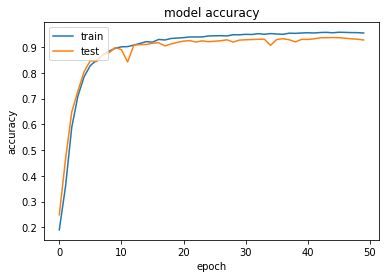

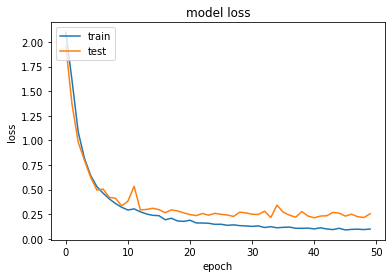

In [18]:
import matplotlib.pyplot as plt

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [66]:
probabilities = model.predict_generator(test_generator)

In [67]:
probabilities.shape

(3973, 10)

In [68]:
probabilities

array([[9.9932158e-01, 6.8932502e-05, 2.4351225e-09, ..., 1.8198135e-08,
        4.5764659e-09, 9.7490215e-07],
       [9.9882919e-01, 2.9734388e-04, 2.6573213e-07, ..., 8.8168417e-06,
        5.3445797e-06, 1.4111078e-04],
       [9.9554670e-01, 1.0253680e-03, 1.5492465e-06, ..., 1.6275024e-05,
        6.7711430e-06, 1.6058935e-04],
       ...,
       [3.0581886e-04, 1.6165153e-09, 9.5557615e-15, ..., 2.2175615e-09,
        1.7382227e-08, 9.9969423e-01],
       [1.2370325e-03, 4.6731210e-09, 1.3841040e-13, ..., 3.9443094e-08,
        2.5038642e-07, 9.9876273e-01],
       [1.2957719e-03, 5.0044818e-08, 1.3251751e-09, ..., 9.3769722e-06,
        2.5288482e-05, 9.9866927e-01]], dtype=float32)

In [69]:
test_pred_labels = np.argmax(probabilities,axis=1)

In [70]:
test_pred_labels
test_pred_labels_onehot = to_categorical(test_pred_labels, num_classes=10)

In [71]:
test_pred_labels_onehot.shape

(3973, 10)

In [72]:
test_labels = test_generator.classes
test_labels_onehot = to_categorical(test_labels, num_classes=10)

In [73]:
test_labels_onehot.shape

(3973, 10)

In [97]:
from textwrap import wrap

In [106]:
class_labels_normal = ['safe_driving', 'texting_right', 'talking_on_phone_right', 'texting_left', 'talking_on_phone_left',
                'operating_radio', 'drinking', 'reaching_behind', 'doing_hair_makeup', 'talking_to_passanger']
class_labels_wraped = [ '\n'.join(wrap(l, 5)) for l in class_labels_normal ]

In [102]:
conf_matrix = confusion_matrix(test_pred_labels, test_labels)
#conf_matrix = conf_matrix.astype('float') 

class_labels_encoded = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']



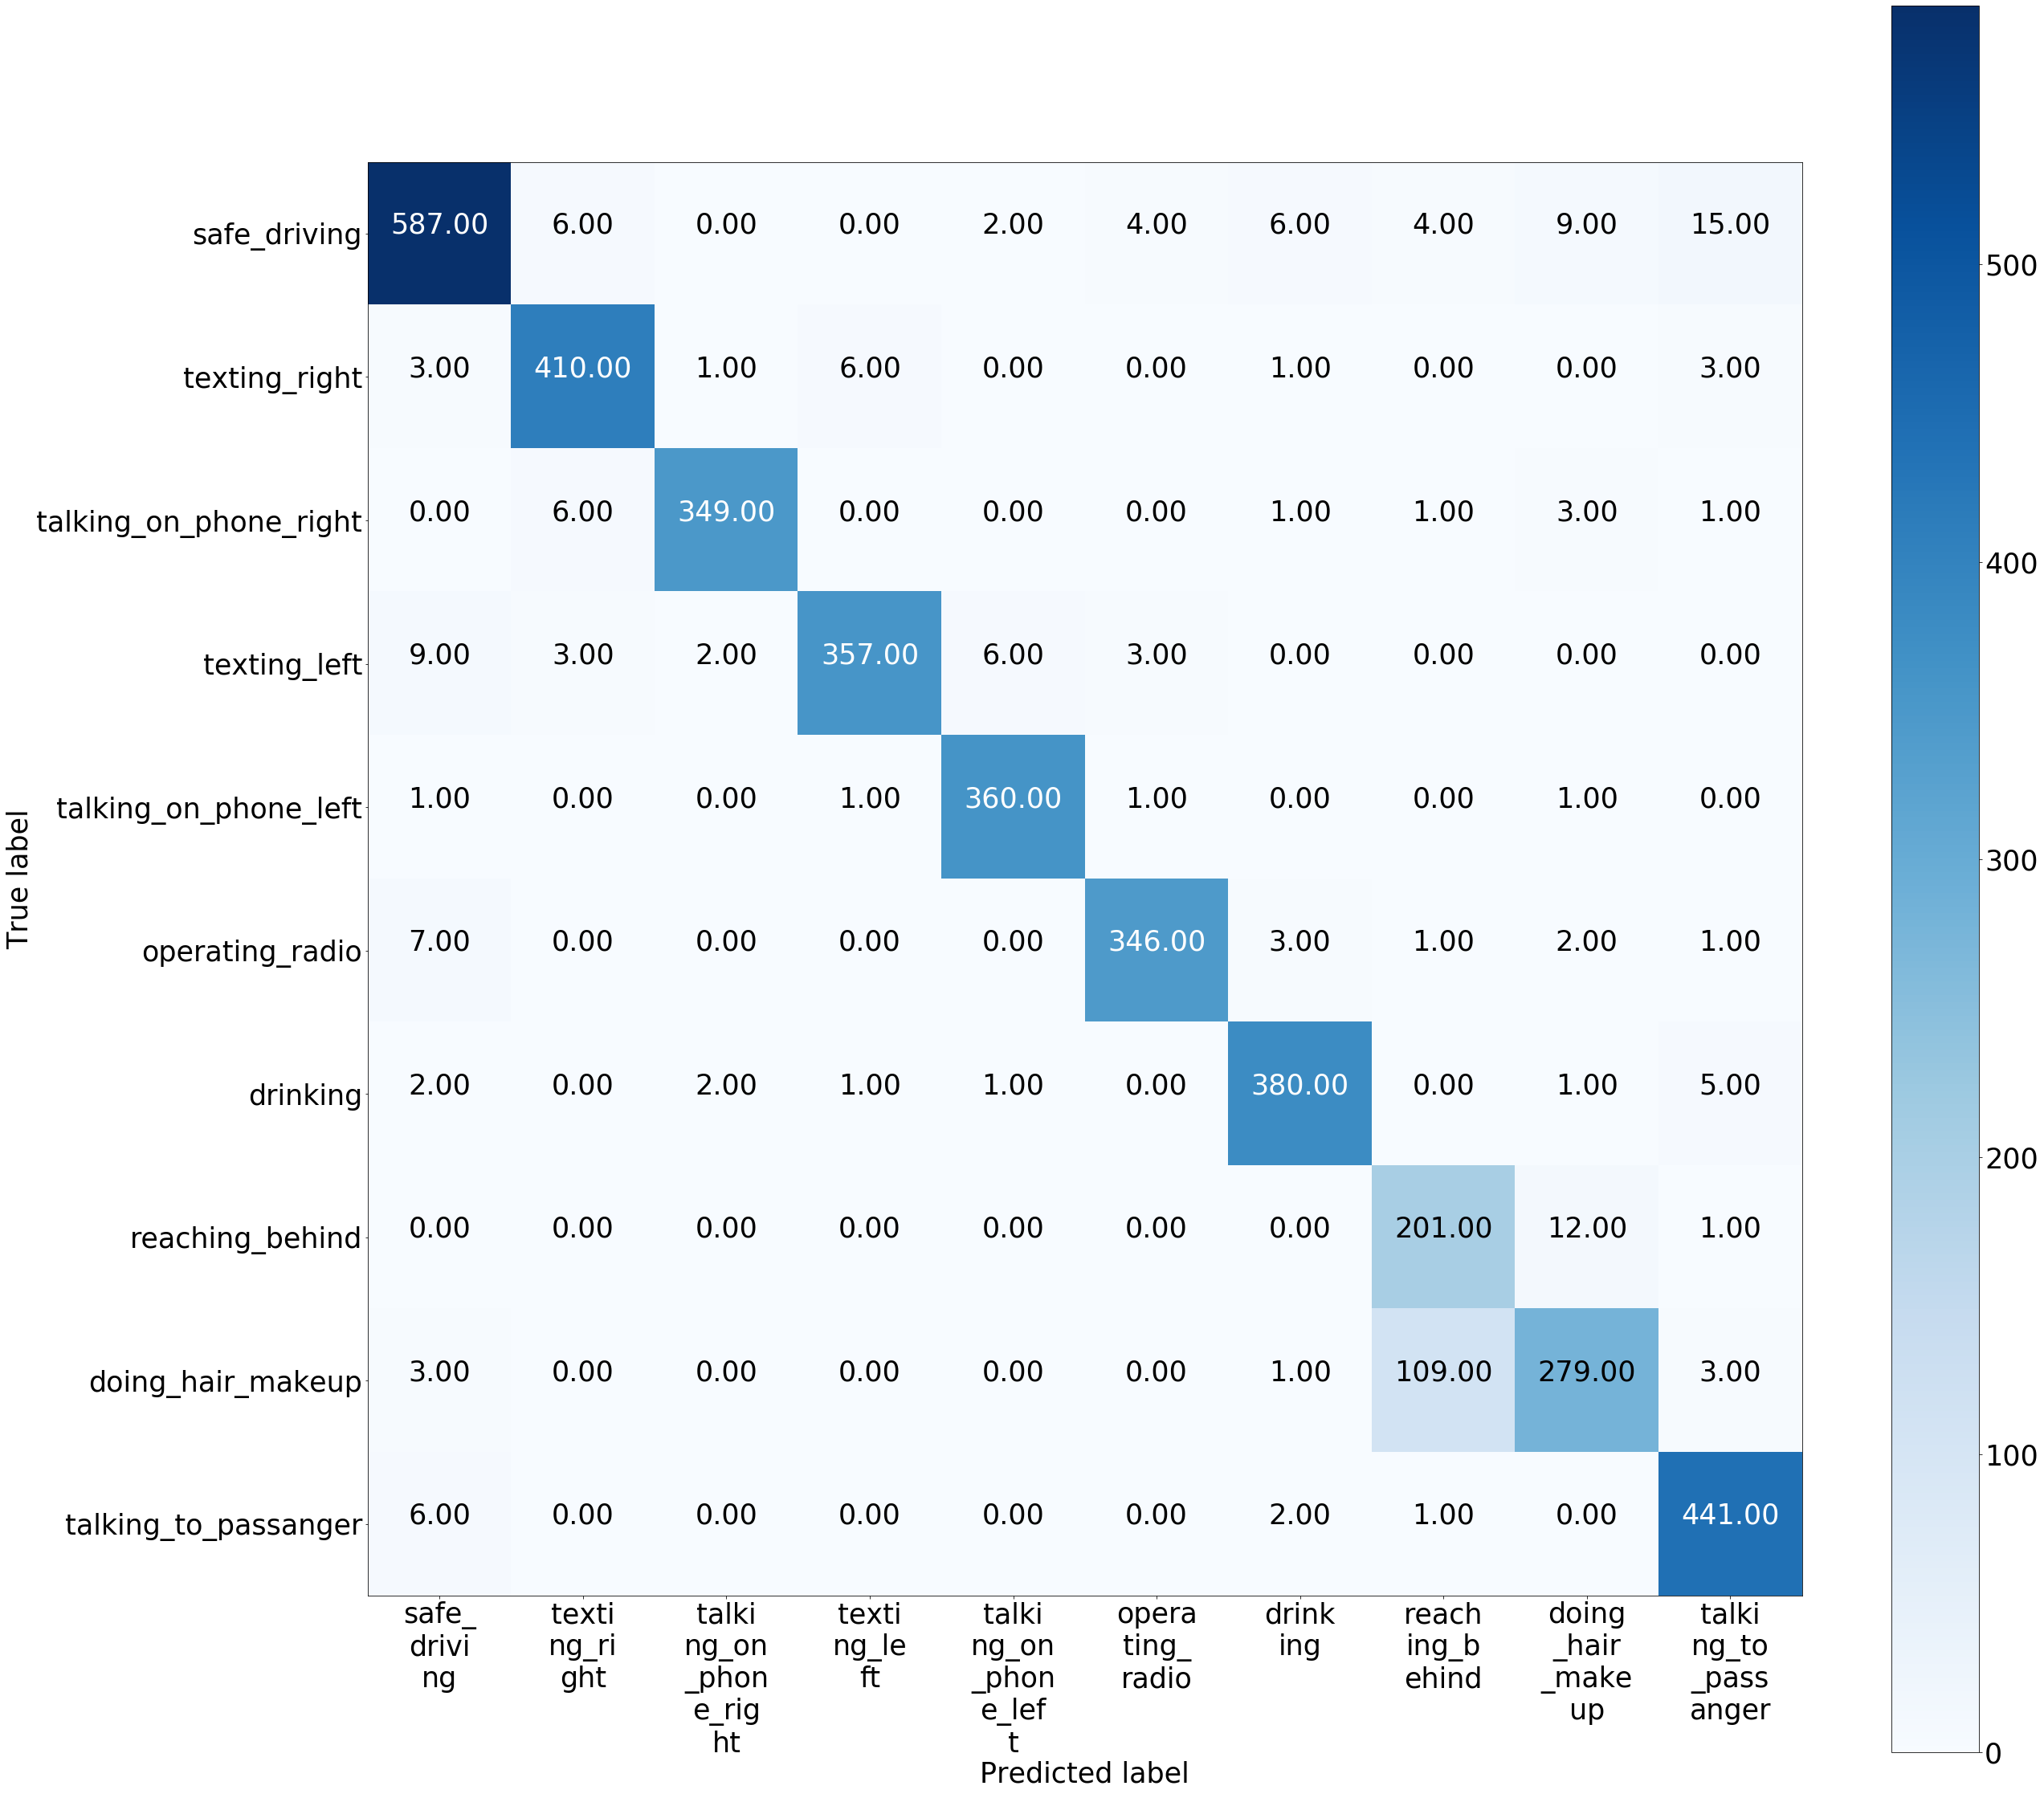

In [108]:
#plt.rcParams.update({'figure.autolayout': False})
plt.rcParams.update({'font.size': 35})
plt.figure(figsize=(40,40))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
tick_marks = np.arange(len(class_labels_normal))
plt.xticks(tick_marks, class_labels_wraped, rotation=0)
plt.yticks(tick_marks, class_labels_normal)
plt.colorbar()
threshold = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if conf_matrix[i, j] > threshold else 'black')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.autoscale()
plt.show()


In [116]:
from tensorflow.keras.models import load_model

In [ ]:
model_saved = load_model('resnet.h5')

In [118]:
model_saved.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 326, 326, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 160, 160, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 160, 160, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [119]:
for layer in model_saved.layers:
    layer.trainable = False

In [121]:
probabilities_1 = model_saved.predict_generator(test_generator)
test_pred_labels_1 = np.argmax(probabilities_1,axis=1)
test_pred_labels_onehot_1 = to_categorical(test_pred_labels_1, num_classes=10)
conf_matrix = confusion_matrix(test_pred_labels_1, test_labels)

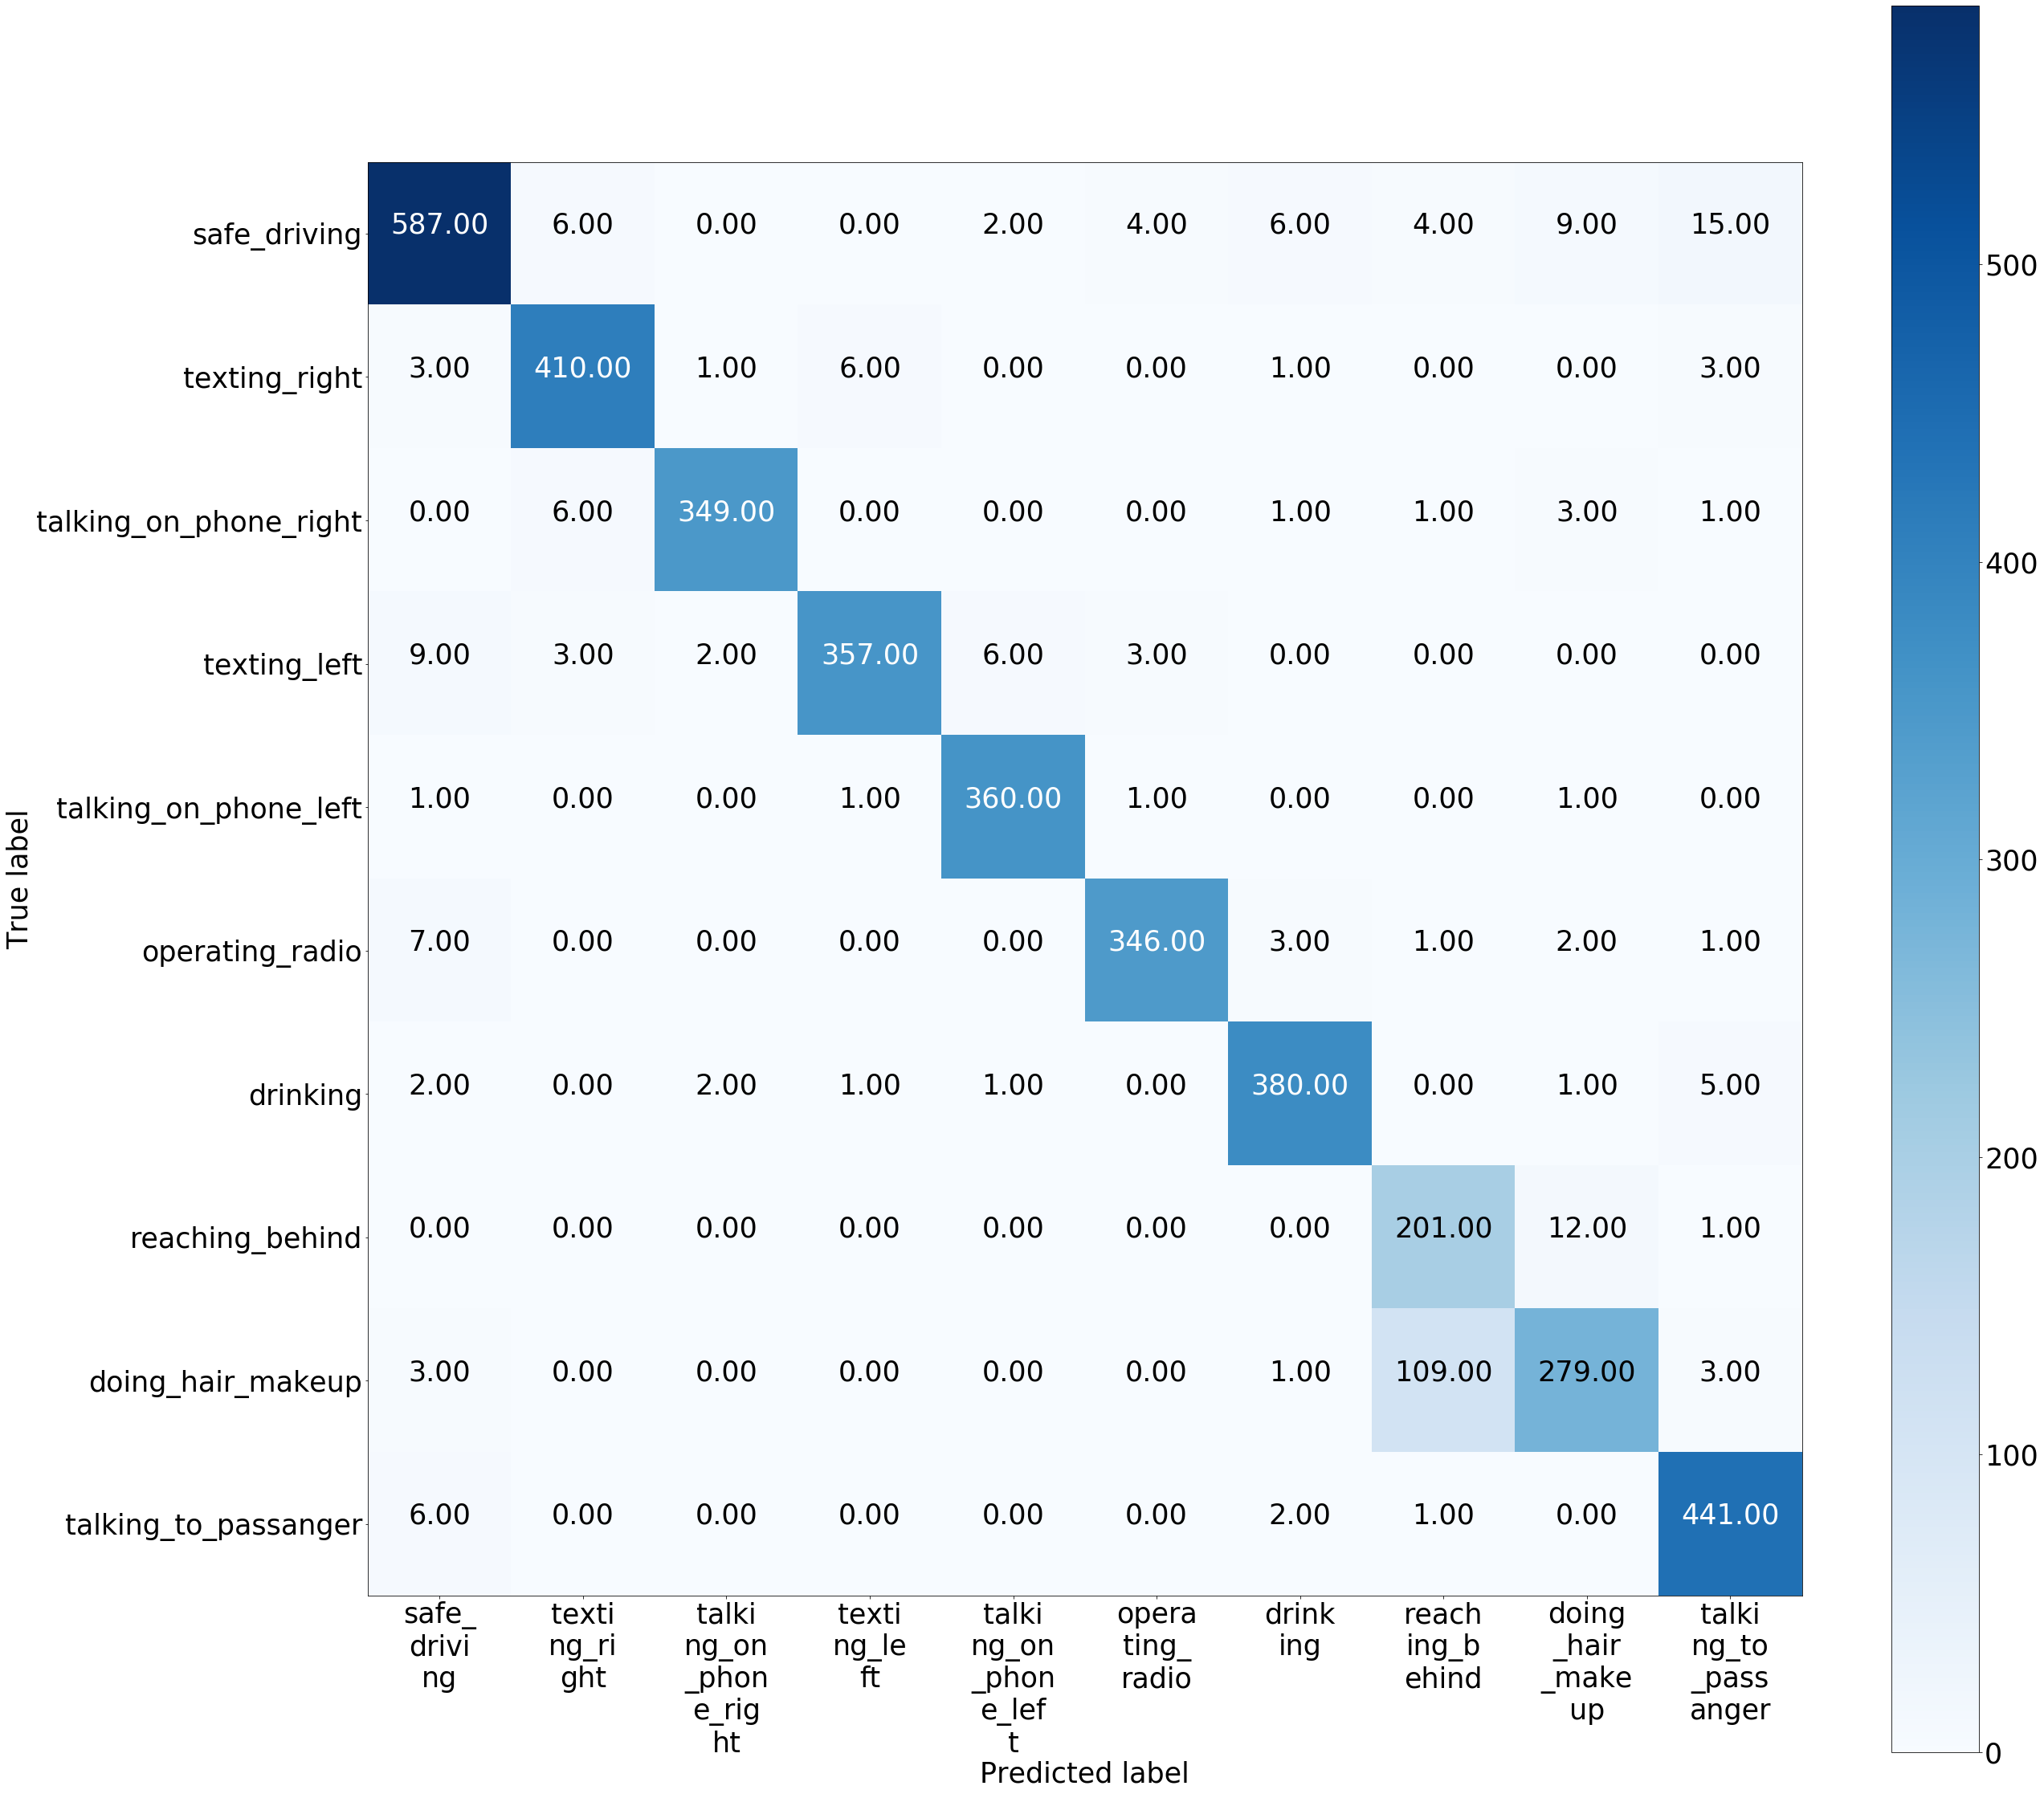

In [122]:
#plt.rcParams.update({'figure.autolayout': False})
plt.rcParams.update({'font.size': 35})
plt.figure(figsize=(40,40))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
tick_marks = np.arange(len(class_labels_normal))
plt.xticks(tick_marks, class_labels_wraped, rotation=0)
plt.yticks(tick_marks, class_labels_normal)
plt.colorbar()
threshold = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if conf_matrix[i, j] > threshold else 'black')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.autoscale()
plt.show()


In [123]:
indices = [i for i,v in enumerate(test_pred_labels_1) if test_pred_labels_1[i]!=test_labels[i]]
for i in indices:
    print(test_generator.filenames[i])
print(len(indices))

c0\1076.jpg
c0\1360.jpg
c0\1680.jpg
c0\1699.jpg
c0\1933.jpg
c0\1934.jpg
c0\1971.jpg
c0\2121.jpg
c0\2153.jpg
c0\2359.jpg
c0\287.jpg
c0\3107.jpg
c0\3115.jpg
c0\3343.jpg
c0\3561.jpg
c0\359.jpg
c0\3622.jpg
c0\3625.jpg
c0\506.jpg
c0\553.jpg
c0\79.jpg
c0\80.jpg
c0\82.jpg
c0\890.jpg
c0\892.jpg
c0\944.jpg
c0\img_12951.jpg
c0\img_13328.jpg
c0\img_73049.jpg
c0\img_87445.jpg
c0\img_97574.jpg
c1\1127.jpg
c1\1335.jpg
c1\1346.jpg
c1\137.jpg
c1\1458.jpg
c1\1750.jpg
c1\1760.jpg
c1\193.jpg
c1\247.jpg
c1\70.jpg
c1\873.jpg
c1\947.jpg
c1\img_11145.jpg
c1\img_44437.jpg
c1\img_84433.jpg
c2\207.jpg
c2\303.jpg
c2\304.jpg
c2\869.jpg
c2\img_69693.jpg
c3\1099.jpg
c3\188.jpg
c3\191.jpg
c3\215.jpg
c3\399.jpg
c3\516.jpg
c3\517.jpg
c3\img_1295.jpg
c4\1046.jpg
c4\1097.jpg
c4\295.jpg
c4\630.jpg
c4\776.jpg
c4\777.jpg
c4\859.jpg
c4\img_41743.jpg
c4\img_71487.jpg
c5\189.jpg
c5\305.jpg
c5\563.jpg
c5\564.jpg
c5\704.jpg
c5\img_44114.jpg
c5\img_8131.jpg
c5\img_82888.jpg
c6\119.jpg
c6\1367.jpg
c6\1433.jpg
c6\1442.jpg
c6\374.j